In [5]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd
import numpy as np

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")           # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")         # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")   # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")    # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")           # Monthly demand in MWh

start_date = "2020-01"
end_date = "2022-12"
fuels = ["coal", "oil", "gas"]
zone = 'DK_1'  # Specify the zone for demand data
resample_method = 'M' # Monthly resampling 

output_path = os.path.join(current_dir.parent, "results", "model3")
os.makedirs(output_path, exist_ok=True)

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method ,zone=zone ,supply_factor=0.6)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")

T = list(range(len(demand_df)))

F = [fuel for fuel in fuel_prices_df.columns if fuel in fuels]

# Initial Storage Levels
initial_storage = {fuel: 0 for fuel in fuel_prices_df.columns if fuel in fuels}

# periods as Month PeriodIndex (so days_in_month works)
periods = demand_df.index.to_period('M')


/Users/lalka/Projects/46750_g28_Assignment_2/src/data_loader.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(resample_method).mean()
/Users/lalka/Projects/46750_g28_Assignment_2/src/data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()


In [6]:
# 1) Scenario definitions
scenario_list = ["low", "standard", "high"]

# 2) Multiplicative factors per fuel and scenario
#    - Gas is most volatile, coal least volatile
#    - Factors are multiplicative: scaled_price = base_price * factor
price_factors = {
    "coal":    {"low": 0.97, "standard": 1.00, "high": 1.03},   # +/- ~3%
    "oil":     {"low": 0.92, "standard": 1.00, "high": 1.08},   # ~8% swing
    "gas":     {"low": 0.80, "standard": 1.00, "high": 1.25},   # large volatility
}

# If you have extra fuels (e.g. 'lignite') present in fuel_prices_df, we preserve them (standard=1.0)
for col in fuel_prices_df.columns:
    if col not in price_factors:
        price_factors[col] = {s: 1.0 for s in scenario_list}

# 3) Seasonal probabilities 
#    Rationale: fuels (especially gas) tend to show seasonal patterns (higher risk of high prices in winter).
#    Seasonal buckets: winter=Dec/Jan/Feb, spring=Mar/Apr/May, summer=Jun/Jul/Aug, autumn=Sep/Oct/Nov
seasonal_scenario_probs = {
    "winter": {"low": 0.10, "standard": 0.40, "high": 0.50},
    "spring": {"low": 0.25, "standard": 0.60, "high": 0.15},
    "summer": {"low": 0.40, "standard": 0.50, "high": 0.10},
    "autumn": {"low": 0.20, "standard": 0.60, "high": 0.20},
}

def month_to_season(month: int) -> str:
    if month in (12, 1, 2):
        return "winter"
    if month in (3, 4, 5):
        return "spring"
    if month in (6, 7, 8):
        return "summer"
    return "autumn"

# 4) Build scenario_prices (dict of DataFrames) and scenario probability DataFrame (indexed by original index)
scenario_prices = {s: fuel_prices_df.copy(deep=True) for s in scenario_list}

# Ensure index is datetime (should be already from your loader) and use it to create probabilities by period
index = fuel_prices_df.index
if not isinstance(index, pd.DatetimeIndex):
    # fallback: if index was integer-range, try to use a 'month' column if present
    if "month" in fuel_prices_df.columns:
        index = pd.to_datetime(fuel_prices_df["month"])
        for df in scenario_prices.values():
            df.index = index
    else:
        raise RuntimeError("fuel_prices_df must have a DatetimeIndex or a 'month' column parseable to dates.")

# Create a DataFrame of probabilities for each period
scenario_prob_df = pd.DataFrame(index=index, columns=scenario_list, dtype=float)

for ts in index:
    season = month_to_season(ts.month)
    probs = seasonal_scenario_probs[season]
    # assign same probabilities for all fuels in that month (you could vary by fuel if desired)
    scenario_prob_df.loc[ts, list(probs.keys())] = [probs[k] for k in scenario_list]

# 5) Create scaled price DataFrames
for scenario in scenario_list:
    df_scaled = fuel_prices_df.copy(deep=True)
    # apply fuel-specific factor for each column
    for fuel in df_scaled.columns:
        factor = price_factors.get(fuel, {}).get(scenario, 1.0)
        # multiply only numeric values
        df_scaled[fuel] = pd.to_numeric(df_scaled[fuel], errors="coerce") * factor
    scenario_prices[scenario] = df_scaled

# 6) Create objects used in stochastic model
scenario_index_to_t = {i: scenario for i, scenario in enumerate(scenario_list)}  # e.g. 0->"low"
# scenario probabilities per time-step as numpy array shaped (T, n_scenarios)
prob_array = scenario_prob_df[scenario_list].to_numpy(dtype=float)

expected_df = sum(
    scenario_prices[sc].multiply(scenario_prob_df[sc], axis=0)
    for sc in scenario_prob_df.columns
)


# - scenario_prices: dict {scenario_name: DataFrame_of_scaled_prices}
# - scenario_prob_df: DataFrame indexed by time with columns ['low','standard','high'] giving probabilities
# - prob_array: numpy array (T x 3) with probabilities for building the stochastic model
# - scenario_list and scenario_index_to_t helpers



In [7]:
# Define helper function to extract and save cost in a nice format
# ---------------------------------------------------------------------
# Helper function: build running-cost dataframe for ANY set of variables
# ---------------------------------------------------------------------
def build_running_cost_df(title, x_var, y_var, s_var, fuel_prices_df, F, T, start_date):
    """
    x_var[(fuel,t)].X, y_var[(fuel,t)].X, s_var[(fuel,t)].X must exist.
    """

    # Generate proper month-end date index
    month_end_dates = pd.date_range(start=start_date, periods=len(T), freq="M")

    rows = []
    acc_cost = 0.0

    for idx, t in enumerate(T):
        row = {"Month": month_end_dates[idx].strftime("%Y-%m-%d")}
        cost_t = 0.0

        for fuel in F:
            bought = x_var[(fuel, t)].X
            generated = y_var[(fuel, t)].X
            stored = s_var[(fuel, t)].X

            row[f"{fuel}_Bought"] = bought
            row[f"{fuel}_Generated"] = generated
            row[f"{fuel}_Stored"] = stored

            cost_t += fuel_prices_df.iloc[t][fuel] * bought

        acc_cost += cost_t
        row["Cost_EUR"] = cost_t
        row["Accumulated_Cost"] = acc_cost

        rows.append(row)

    df = pd.DataFrame(rows)


    # Fix column capitalization

    rename_map = {
    "coal_Bought": "Coal_Bought",
    "oil_Bought": "Oil_Bought",
    "gas_Bought": "Gas_Bought",
    "coal_Generated": "Coal_Generated",
    "oil_Generated": "Oil_Generated",
    "gas_Generated": "Gas_Generated",
    "coal_Stored": "Coal_Stored",
    "oil_Stored": "Oil_Stored",
    "gas_Stored": "Gas_Stored"
}
    df = df.rename(columns=rename_map)

    # Column order
    desired_order = [
        "Month", "Cost_EUR", "Accumulated_Cost",
        "Coal_Bought", "Oil_Bought", "Gas_Bought",
        "Coal_Generated", "Oil_Generated", "Gas_Generated",
        "Coal_Stored", "Oil_Stored", "Gas_Stored"
    ]

    return df[desired_order]

In [8]:
# -----------------------------------------------------------------------------
# Running three Deterministic Models (Perfect Foresight) for Comparison
# -----------------------------------------------------------------------------
# Ensure these variables exist from your previous cells
assert "scenario_list" in globals(), "Please run the data loading/scenario generation cell first."
assert "scenario_prices" in globals(), "Please run the data loading/scenario generation cell first."

deterministic_results = {}  # To store the objective value (Total Cost) for each scenario
detailed_schedules = {}     # To store the detailed DataFrames for each scenario

print(f"Running deterministic models for scenarios: {scenario_list}\n")

# -----------------------------------------------------------------------------
# Loop through each scenario and solve a standard Deterministic Model
# -----------------------------------------------------------------------------
for sname in scenario_list:
    print(f"--- Solving Deterministic Model for Scenario: {sname} ---")
    
    # 1. Get the specific price dataframe for this scenario
    current_prices = scenario_prices[sname]
    
    # 2. Initialize Model
    m_det = Model(f"Fuel_Procurement_Deterministic_{sname}")
    m_det.params.OutputFlag = 0  # Mute Gurobi output to keep console clean (set to 1 to see logs)

    # 3. Decision Variables
    # Buying (x), Withdrawal (w), Storage (s)
    x = {(fuel, t): m_det.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}_{t}")
         for fuel in F for t in T}
    
    w = {(fuel, t): m_det.addVar(lb=0, ub=storage[fuel], name=f"cons_{fuel}_{t}")
         for fuel in F for t in T}
    
    s = {(fuel, t): m_det.addVar(lb=0, ub=storage[fuel], name=f"s_{fuel}_{t}")
         for fuel in F for t in T}

    # Generation (y) - recalculating capacity per month just like the original model
    y = {}
    for fuel in F:
        for t in T:
            hours_in_month = periods[t].days_in_month * 24
            monthly_capacity_mwh = plant_capacity.get(fuel, 0) * hours_in_month
            y[fuel, t] = m_det.addVar(lb=0, ub=monthly_capacity_mwh, name=f"use_{fuel}_{t}")

    m_det.update()

    # 4. Constraints
    
    # Demand
    for t in T:
        m_det.addConstr(
            sum(y[fuel, t] for fuel in F) >= int(demand_df.iloc[t][zone]),
            name=f"Demand_{t}"
        )

    # Efficiency & Conversion
    for fuel in F:
        for t in T:
            m_det.addConstr(
                y[fuel, t] == efficiency[fuel] * w[fuel, t],
                name=f"Gen_from_Cons_{fuel}_{t}"
            )

    # SOE Dynamics
    for fuel in F:
        for t in T:
            if t == 0:
                m_det.addConstr(
                    s[fuel, t] == initial_storage[fuel] + x[fuel, t] - w[fuel, t],
                    name=f"SOE_Def_{fuel}_{t}"
                )
            else:
                m_det.addConstr(
                    s[fuel, t] == s[fuel, t-1] + x[fuel, t] - w[fuel, t],
                    name=f"SOE_Def_{fuel}_{t}"
                )
            
            # Explicit Storage Limit
            m_det.addConstr(s[fuel, t] <= storage[fuel], name=f"SOE_Limit_{fuel}_{t}")

    # Cyclic SOE (start == end)
    for fuel in F:
        m_det.addConstr(s[fuel, 0] == s[fuel, T[-1]], name=f"SOE_Cycle_{fuel}")

    # 5. Objective: Minimize Cost using CURRENT SCENARIO PRICES
    # Note: We use `current_prices` (which is scenario_prices[sname])
    obj_expr = sum(current_prices.iloc[t][fuel] * x[fuel, t] for fuel in F for t in T)
    m_det.setObjective(obj_expr, GRB.MINIMIZE)
    
    # 6. Optimize
    m_det.optimize()

    # 7. Process Results
    if m_det.status == GRB.OPTIMAL:
        cost = m_det.ObjVal
        deterministic_results[sname] = cost
        print(f"  -> Optimal Solution Found. Total Cost: EUR {cost:,.2f}")
        
        # Extract detailed schedule for this scenario
        # Create a dataframe similar to the ones in your stochastic output
        cols = []
        for fuel in F:
            cols += [(fuel, 'bought'), (fuel, 'generated'), (fuel, 'stored')]
        
        # Use the same index as the main dataframe
        idx = current_prices.index
        df_res = pd.DataFrame(index=idx, columns=pd.MultiIndex.from_tuples(cols, names=['fuel','metric']), dtype=float)
        
        for t, ts in enumerate(idx):
            for fuel in F:
                df_res.loc[ts, (fuel, 'bought')] = x[fuel, t].X
                df_res.loc[ts, (fuel, 'generated')] = y[fuel, t].X
                df_res.loc[ts, (fuel, 'stored')] = s[fuel, t].X
        
        detailed_schedules[sname] = df_res

        # start_date as "YYYY-MM" (first month in this scenario's prices index)
        start_date = current_prices.index[0].strftime("%Y-%m")

        run_df = build_running_cost_df(
            title=f"deterministic_{sname}",
            x_var=x,
            y_var=y,
            s_var=s,
            fuel_prices_df=current_prices,  # scenario-specific prices
            F=F,
            T=T,
            start_date=start_date
        )

        csv_path = os.path.join(output_path, f"deterministic_running_costs_{sname}.csv")
        run_df.to_csv(csv_path, index=False)
        print(f"Saved deterministic running-costs for scenario '{sname}' → {csv_path}")
        
    else:
        print(f"  -> No optimal solution found (Status Code: {m_det.status})")
        deterministic_results[sname] = None

# -----------------------------------------------------------------------------
# Summary Report
# -----------------------------------------------------------------------------
print("\n" + "="*50)
print("COMPARISON: PERFECT FORESIGHT (DETERMINISTIC) COSTS")
print("="*50)
print(f"{'Scenario':<15} | {'Total Cost (EUR)':<20}")
print("-" * 38)
for sname in scenario_list:
    val = deterministic_results.get(sname)
    if val is not None:
        print(f"{sname:<15} | {val:,.2f}")
    else:
        print(f"{sname:<15} | Infeasible/Error")
print("="*50)


Running deterministic models for scenarios: ['low', 'standard', 'high']

--- Solving Deterministic Model for Scenario: low ---
  -> Optimal Solution Found. Total Cost: EUR 2,373,442,608.41
Saved deterministic running-costs for scenario 'low' → /Users/lalka/Projects/46750_g28_Assignment_2/results/model3/deterministic_running_costs_low.csv
--- Solving Deterministic Model for Scenario: standard ---
  -> Optimal Solution Found. Total Cost: EUR 2,825,611,134.40
Saved deterministic running-costs for scenario 'standard' → /Users/lalka/Projects/46750_g28_Assignment_2/results/model3/deterministic_running_costs_standard.csv
--- Solving Deterministic Model for Scenario: high ---
  -> Optimal Solution Found. Total Cost: EUR 3,335,988,019.17
Saved deterministic running-costs for scenario 'high' → /Users/lalka/Projects/46750_g28_Assignment_2/results/model3/deterministic_running_costs_high.csv

COMPARISON: PERFECT FORESIGHT (DETERMINISTIC) COSTS
Scenario        | Total Cost (EUR)    
----------------

/var/folders/bp/wwf437ks68j7y4307x_22ryw0000z9/T/ipykernel_37284/2062245461.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = pd.date_range(start=start_date, periods=len(T), freq="M")
/var/folders/bp/wwf437ks68j7y4307x_22ryw0000z9/T/ipykernel_37284/2062245461.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = pd.date_range(start=start_date, periods=len(T), freq="M")
/var/folders/bp/wwf437ks68j7y4307x_22ryw0000z9/T/ipykernel_37284/2062245461.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = pd.date_range(start=start_date, periods=len(T), freq="M")


In [9]:
# Model the stochastic extensive-form model
# -------------------------

# Map period index (Datetimes) -> integer t (must match T from deterministic model)
period_index = fuel_prices_df.index  # should be a DatetimeIndex
if not isinstance(period_index, pd.DatetimeIndex):
    raise RuntimeError("fuel_prices_df index must be a DatetimeIndex for per-period probabilities to work.")

# ensure length matches T
if len(period_index) != len(T):
    raise RuntimeError("Length of fuel_prices_df index does not match T. Check data loader outputs.")

# Build probability matrix: prob_array[t, i_s]
n_scen = len(scenario_list)
scenario_prob_df = scenario_prob_df.reindex(index=period_index)[scenario_list]
prob_array = scenario_prob_df.to_numpy(dtype=float)

if prob_array.shape != (len(T), n_scen):
    raise RuntimeError(f"prob_array shape mismatch. Expected ({len(T)}, {n_scen}).")

# -----------------------------------------------------------------------------
# 2. BUILD STOCHASTIC MODEL (EXTENSIVE FORM)
# -----------------------------------------------------------------------------
m_stoch = Model("Fuel_Procurement_Stochastic_ExtensiveForm")

# Variables indexed by (scenario, fuel, time)
x_s = {}    # Buy
y_s = {}    # Generate
w_s = {}    # Withdraw (Consume)
soe_s = {}  # Storage State of Energy

print("Building variables and constraints...")

for sname in scenario_list:
    for f in F:
        for t in T:
            # Variables
            x_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"x_{sname}_{f}_{t}")
            w_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"w_{sname}_{f}_{t}")
            soe_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=storage[f], name=f"s_{sname}_{f}_{t}")
            
            hours_in_month = periods[t].days_in_month * 24
            monthly_capacity_mwh = plant_capacity.get(f, 0) * hours_in_month
            y_s[(sname, f, t)] = m_stoch.addVar(lb=0, ub=monthly_capacity_mwh, name=f"use_{sname}_{f}_{t}")

m_stoch.update()

# Constraint 1: Non-Anticipativity (Decisions at t=0 must be identical across all scenarios)
if len(scenario_list) > 1:
    base_s = scenario_list[0]
    for f in F:
        for t in [0]:  # change to range(k+1) to make NA for more periods
            for sname in scenario_list[1:]:
                m_stoch.addConstr(x_s[(base_s, f, t)] == x_s[(sname, f, t)], name=f"NA_x_{f}_{t}_{sname}")
                m_stoch.addConstr(y_s[(base_s, f, t)] == y_s[(sname, f, t)], name=f"NA_y_{f}_{t}_{sname}")
                m_stoch.addConstr(w_s[(base_s, f, t)] == w_s[(sname, f, t)], name=f"NA_w_{f}_{t}_{sname}")
                m_stoch.addConstr(soe_s[(base_s, f, t)] == soe_s[(sname, f, t)], name=f"NA_s_{f}_{t}_{sname}")

# Scenario-wise constraints
for sname in scenario_list:
    price_df = scenario_prices[sname]  # not needed for constraints if only used in objective
    for t in T:
        # deterministic demand used per-scenario here (change if you want scenario-specific demand)
        m_stoch.addConstr(
            sum(y_s[(sname, f, t)] for f in F) >= float(demand_df.iloc[t][zone]),
            name=f"Demand_{sname}_{t}"
        )

    for f in F:
        for t in T:
            # link generation to fuel consumed: electricity = efficiency * fuel_withdrawn
            m_stoch.addConstr(
                y_s[(sname, f, t)] == efficiency[f] * w_s[(sname, f, t)],
                name=f"Conv_{sname}_{f}_{t}"
            )

            # SOE dynamics: storage increases with purchases x and decreases with withdrawals w
            if t == 0:
                m_stoch.addConstr(
                    soe_s[(sname, f, t)] == initial_storage[f] + x_s[(sname, f, t)] - w_s[(sname, f, t)],
                    name=f"SOE_def_{sname}_{f}_{t}"
                )
            else:
                m_stoch.addConstr(
                    soe_s[(sname, f, t)] == soe_s[(sname, f, t-1)] + x_s[(sname, f, t)] - w_s[(sname, f, t)],
                    name=f"SOE_def_{sname}_{f}_{t}"
                )

            # storage limit (explicit)
            m_stoch.addConstr(soe_s[(sname, f, t)] <= storage[f], name=f"SOE_lim_{sname}_{f}_{t}")

        # cyclic SOE
        m_stoch.addConstr(soe_s[(sname, f, 0)] == soe_s[(sname, f, T[-1])], name=f"SOE_cycle_{sname}_{f}")
        
m_stoch.update()

# Objective: expected cost using per-period probabilities prob_array[t, i_s]
expected_cost_expr = 0.0
for i_s, sname in enumerate(scenario_list):
    price_df = scenario_prices[sname]
    for t in T:
        prob_ts = float(prob_array[t, i_s])  # probability of scenario s at time t
        # guard: if prob_ts==0 we still include term (it will be zero)
        for f in F:
            p = price_df.iloc[t].get(f, np.nan)
            if pd.isna(p):
                p = 0.0
            expected_cost_expr += prob_ts * p * x_s[(sname, f, t)]

m_stoch.setObjective(expected_cost_expr, GRB.MINIMIZE)
m_stoch.update()

# -----------------------------------------------------------------------------
# 3. OPTIMIZE & EXTRACT RESULTS
# -----------------------------------------------------------------------------
print("Solving Stochastic Model...")
m_stoch.params.OutputFlag = 1
m_stoch.optimize()

if m_stoch.status == GRB.OPTIMAL:
    print(f"\nOptimal Expected Cost: EUR {m_stoch.ObjVal:,.2f}")

    # ---- Build EXPECTED pseudo-variables (only thing needed for reporting) ----
    x_exp = {}
    y_exp = {}
    s_exp = {}

    for f in F:
        for t in T:
            exp_b, exp_g, exp_s = 0.0, 0.0, 0.0
            for i_s, sname in enumerate(scenario_list):
                p = float(prob_array[t, i_s])
                exp_b += p * x_s[(sname, f, t)].X
                exp_g += p * y_s[(sname, f, t)].X
                exp_s += p * soe_s[(sname, f, t)].X

            # tiny wrapper objects so build_running_cost_df can access .X
            x_exp[(f, t)] = type("Tmp", (), {"X": exp_b})
            y_exp[(f, t)] = type("Tmp", (), {"X": exp_g})
            s_exp[(f, t)] = type("Tmp", (), {"X": exp_s})

    # ---- Build nice running-cost table for the EXPECTED plan ----
    exp_df = build_running_cost_df(
        "stochastic_expected",
        x_var=x_exp,
        y_var=y_exp,
        s_var=s_exp,
        fuel_prices_df=fuel_prices_df,  # base prices or whichever you want for reporting
        F=F,
        T=T,
        start_date="2020-01"
    )

    # ---- Save ONLY this table ----
    results_dir = os.path.join(current_dir.parent, "results", "model3")
    os.makedirs(results_dir, exist_ok=True)
    exp_df.to_csv(os.path.join(results_dir, "stochastic_expected_running_cost.csv"), index=False)

    print("\nSaved expected-value result table to:")
    print(os.path.join(results_dir, "stochastic_expected_running_cost.csv"))
    print("\nPreview:")
    print(exp_df.head())
else:
    print("Stochastic model did not solve to optimality.")

Building variables and constraints...
Solving Stochastic Model...
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1113 rows, 1296 columns and 2649 nonzeros
Model fingerprint: 0x048a726b
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [5e-01, 1e+02]
  Bounds range     [3e+05, 3e+06]
  RHS range        [9e+05, 3e+06]
Presolve removed 689 rows and 351 columns
Presolve time: 0.00s
Presolved: 424 rows, 945 columns, 1587 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2600388e+07   1.896565e+08   0.000000e+00      0s
     327    2.5499540e+09   0.000000e+00   0.000000e+00      0s

Solved in 327 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.549954021e+09

Optimal Expected Cost: EUR 2,549,954,021.08

Saved expecte

/var/folders/bp/wwf437ks68j7y4307x_22ryw0000z9/T/ipykernel_37284/2062245461.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_end_dates = pd.date_range(start=start_date, periods=len(T), freq="M")


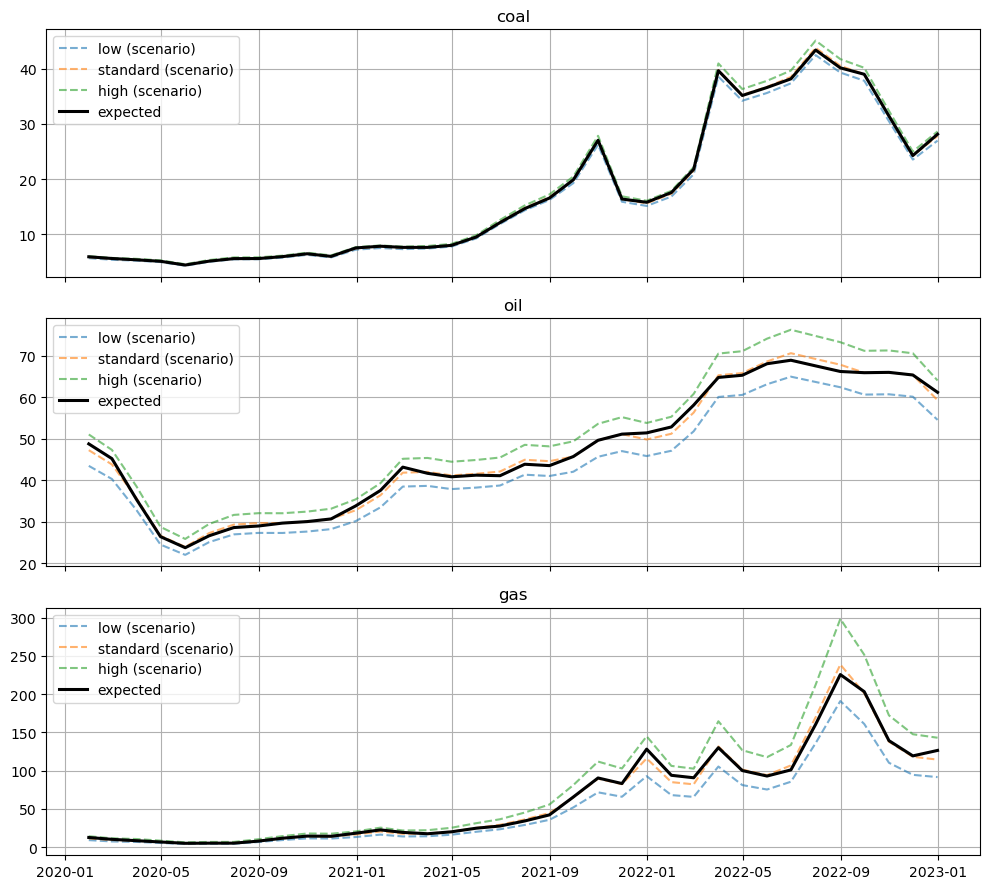

Example (coal) — first 8 periods:   (index, dict: low,standard,high,expected,min,max)
2020-01-31 {'low': 5.699738013287441, 'standard': 5.876018570399424, 'high': 6.052299127511406, 'expected': 5.946530793244217, 'min_scenario': 5.699738013287441, 'max_scenario': 6.052299127511406}
2020-02-29 {'low': 5.405407375716608, 'standard': 5.572584923419184, 'high': 5.739762471121759, 'expected': 5.639455942500214, 'min_scenario': 5.405407375716608, 'max_scenario': 5.739762471121759}
2020-03-31 {'low': 5.250430721203873, 'standard': 5.412815176498839, 'high': 5.575199631793804, 'expected': 5.396576730969342, 'min_scenario': 5.250430721203873, 'max_scenario': 5.575199631793804}
2020-04-30 {'low': 4.993638626964433, 'standard': 5.14808105872622, 'high': 5.3025234904880065, 'expected': 5.132636815550041, 'min_scenario': 4.993638626964433, 'max_scenario': 5.3025234904880065}
2020-05-31 {'low': 4.332886656527656, 'standard': 4.466893460337789, 'high': 4.600900264147922, 'expected': 4.453492779956775

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1) Build expected_prices if you don't already have it
expected_prices = sum(
    scenario_prices[s].multiply(scenario_prob_df[s], axis=0)
    for s in scenario_prob_df.columns
)

# sanity: expected_prices index should match period_index
expected_prices = expected_prices.reindex(index=period_index)

# --- 2) Simple plot: scenarios + expected for each fuel
fuels = ['coal','oil','gas']   # adapt if you have different names or extra fuels
n = len(fuels)
fig, axs = plt.subplots(n, 1, figsize=(10, 3*n), sharex=True)
if n == 1:
    axs = [axs]
for ax, f in zip(axs, fuels):
    # plot each scenario
    for s in scenario_list:
        if f in scenario_prices[s].columns:
            ax.plot(scenario_prices[s].index, scenario_prices[s][f], linestyle='--', alpha=0.6, label=f"{s} (scenario)")
    # plot expected
    ax.plot(expected_prices.index, expected_prices[f], linewidth=2.2, label="expected", color='black')
    ax.set_title(f)
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

# --- 3) Print a small table: for first few periods, show scenario values + expected + min/max
display_cols = ['low','standard','high','expected','min_scenario','max_scenario']
summary = []
for t in range(min(8, len(period_index))):  # first 8 months
    row = {}
    idx = period_index[t]
    for s in scenario_list:
        row[s] = scenario_prices[s].iloc[t].get(fuels[0], np.nan)  # this is just an example for coal; adapt or loop fuels
    row['expected'] = expected_prices.iloc[t][fuels[0]]
    row['min_scenario'] = min(scenario_prices[s].iloc[t][fuels[0]] for s in scenario_list)
    row['max_scenario'] = max(scenario_prices[s].iloc[t][fuels[0]] for s in scenario_list)
    summary.append((idx, row))
# Example print for coal only:
print("Example (coal) — first 8 periods:   (index, dict: low,standard,high,expected,min,max)")
for idx, r in summary:
    print(idx.date(), r)

# --- 4) Check probability normalization (per-period)
prob_sums = scenario_prob_df.sum(axis=1)
print("\nProbability sums (first 12 periods):")
print(prob_sums.head(12))

# --- 5) Compare expected unit price from objective coefficients:
# If you want to verify expected price equals sum of objective coefficients for the t, f group:
# compute expected unit price from scenario coefficients: sum_s prob[t,s] * price_s[t,f]
# (that's the same as expected_prices above; this is just explicit)
calc_expected = []
for t in range(len(period_index)):
    ep = 0.0
    for i_s, sname in enumerate(scenario_list):
        p = scenario_prices[sname].iloc[t].get('coal', 0.0)   # example for coal
        prob_t = float(prob_array[t, i_s])
        ep += prob_t * p
    calc_expected.append(ep)
print("\ncalc_expected (coal) head:", calc_expected[:6])
print("expected_prices (coal) head:", list(expected_prices['coal'].iloc[:6]))

# --- 6) If you want to compute expected total purchase-cost of a solution (given a purchases DF):
# Suppose you have det_df (or exp_df) of purchases `bought` as in your notebook:
# expected_cost_by_t = sum_s prob[t,s] * sum_f price_s[t,f] * x_s_val  (this replicates the obj)
# I'll leave this as a snippet you can adapt below.
